## GEO2R in Colab

Slightly modified and simplified code produced by [GEO2R](https://www.ncbi.nlm.nih.gov/geo/geo2r/) for series [GSE5926](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE5926). Modifications done by Brona Brejova (BB).

* To run all cells of the notebook: Main menu `Runtime`, `Run all`.
* To set up R as the language  `Runtime`, `Change runtime type`, `Runtime type` choose `R`.



In [1]:
# BB: install libraries as ubuntu packages
system("apt update")
system("apt install -y r-bioc-all r-bioc-geoquery")

In [2]:
# Version info: R 4.2.2, Biobase 2.58.0, GEOquery 2.66.0, limma 3.54.0
################################################################
#   Differential expression analysis with limma
library(GEOquery)
library(limma)
#BB: skipped umap due to difficulties with installation
#library(umap)

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Setting options('download.file.method.GEOquery'='auto')

Setting options('GEOquery.inmemory.gpl'=FALSE)


Attaching package: ‘limma’


The fol

In [3]:
# load series and platform data from GEO
gset <- getGEO("GSE5926", GSEMatrix =TRUE, AnnotGPL=TRUE)
if (length(gset) > 1) idx <- grep("GPL90", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]

# make proper column names to match toptable
fvarLabels(gset) <- make.names(fvarLabels(gset))

# group membership for all samples
gsms <- "000111XXXXXXXXX"
sml <- strsplit(gsms, split="")[[1]]

# filter out excluded samples (marked as "X")
sel <- which(sml != "X")
sml <- sml[sel]
gset <- gset[ ,sel]

Found 1 file(s)

GSE5926_series_matrix.txt.gz



In [4]:

# log2 transformation
ex <- exprs(gset)
qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) ||
          (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { ex[which(ex <= 0)] <- NaN
  exprs(gset) <- log2(ex) }

In [5]:
# assign samples to groups and set up design matrix
gs <- factor(sml)
groups <- make.names(c("ref","ac"))
levels(gs) <- groups
gset$group <- gs
design <- model.matrix(~group + 0, gset)
colnames(design) <- levels(gs)

gset <- gset[complete.cases(exprs(gset)), ] # skip missing values

fit <- lmFit(gset, design)  # fit linear model

# set up contrasts of interest and recalculate model coefficients
cts <- paste(groups[1], groups[2], sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

# compute statistics and table of top significant genes
fit2 <- eBayes(fit2, 0.01)
tT <- topTable(fit2, adjust="fdr", sort.by="B", number=250)
tT <- subset(tT, select=c("ID","adj.P.Val","P.Value","t","B","logFC","Gene.title"))
# BB: skip "ORF","SPOT_ID","Gene.Symbol","Gene.symbol", not present

# BB: skip writing full table
# write.table(tT, file=stdout(), row.names=F, sep="\t")

[1] "ref-ac"

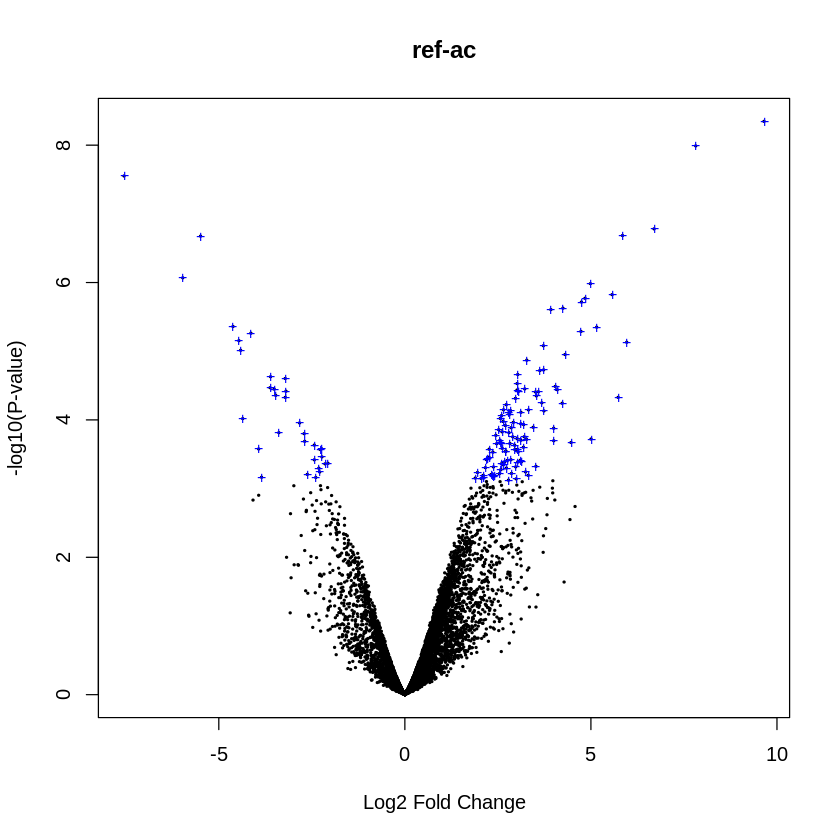

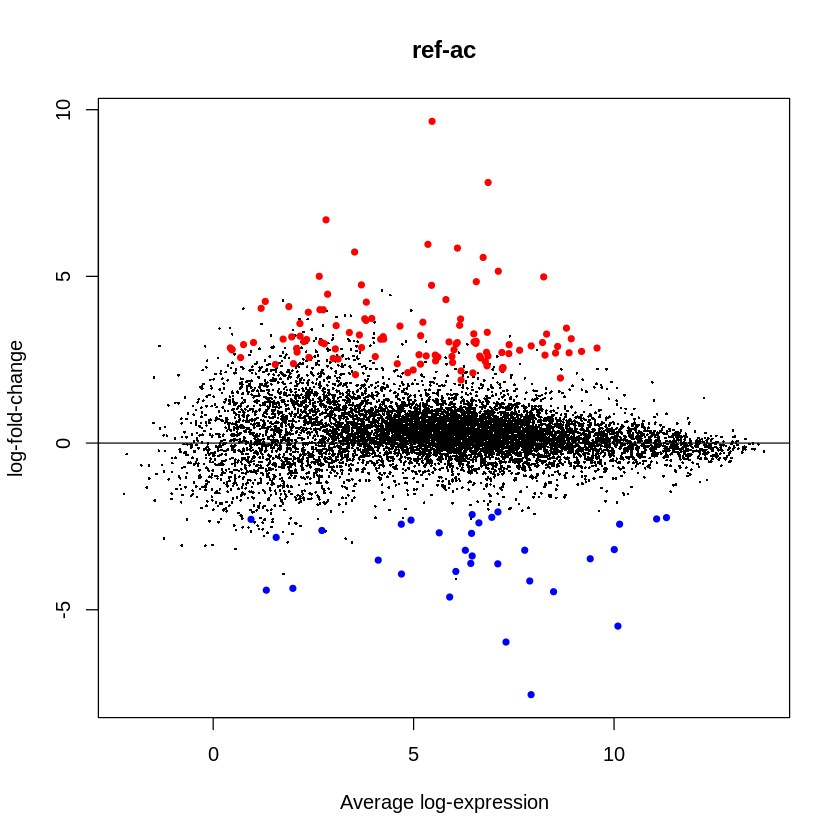

In [6]:
# Visualize and quality control test results.

# BB: in this example only volcano and MD plots shown

# summarize test results as "up", "down" or "not expressed"
dT <- decideTests(fit2, adjust.method="fdr", p.value=0.05, lfc=0)


# volcano plot (log P-value vs log fold change)
colnames(fit2) # list contrast names
ct <- 1        # choose contrast of interest
# Please note that the code provided to generate graphs serves as a guidance to
# the users. It does not replicate the exact GEO2R web display due to multitude
# of graphical options.
#
# The following will produce basic volcano plot using limma function:
volcanoplot(fit2, coef=ct, main=colnames(fit2)[ct], pch=20,
  highlight=length(which(dT[,ct]!=0)), names=rep('+', nrow(fit2)))

# MD plot (log fold change vs mean log expression)
# highlight statistically significant (p-adj < 0.05) probes
plotMD(fit2, column=ct, status=dT[,ct], legend=F, pch=20, cex=1)
abline(h=0)


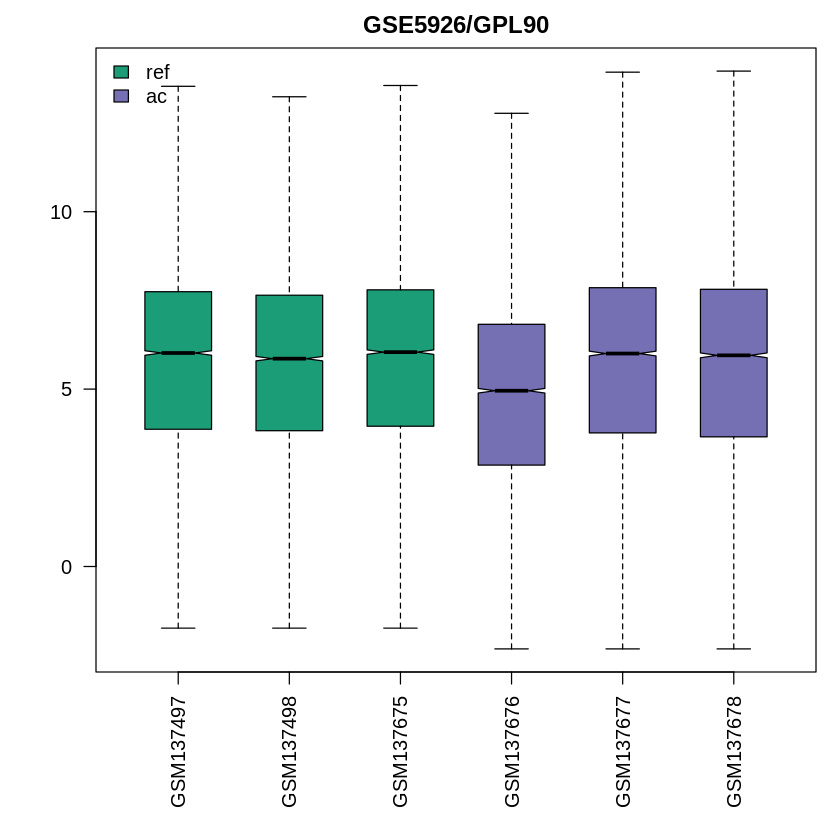

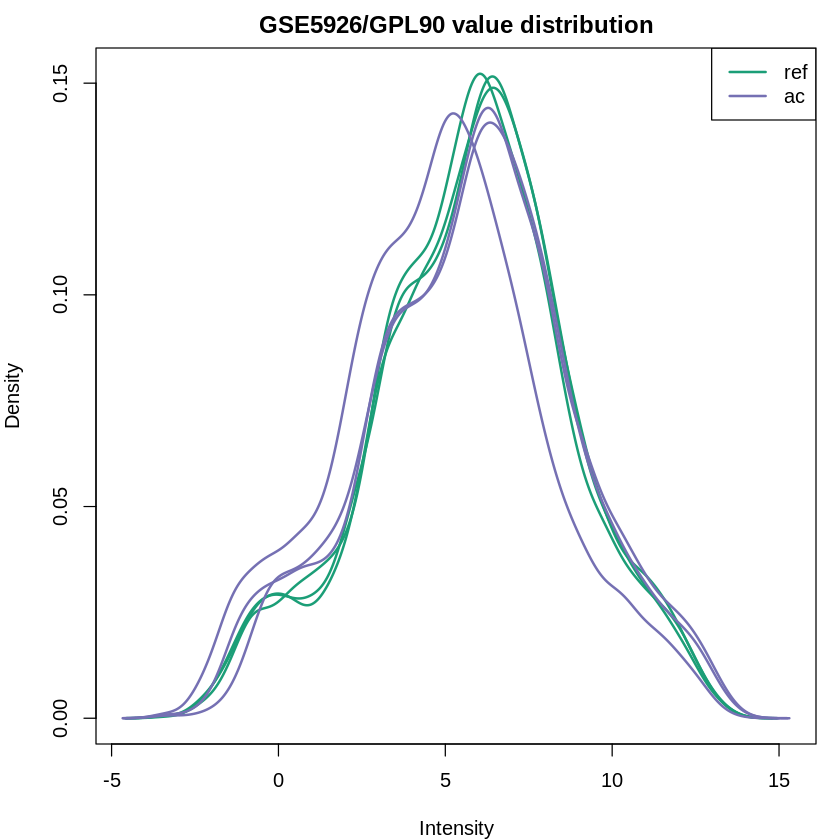

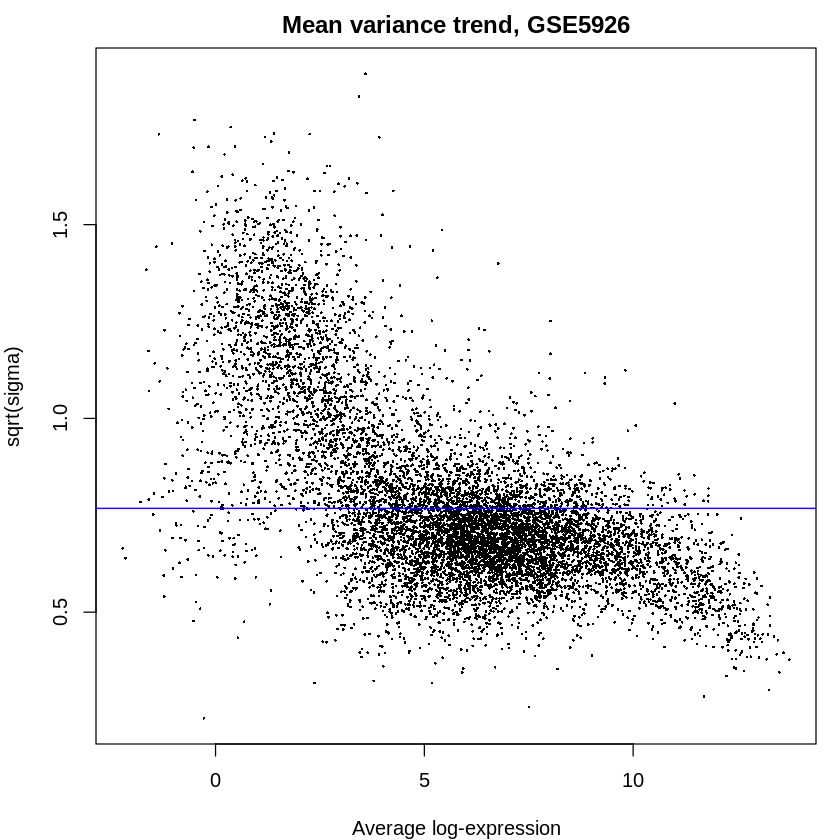

In [7]:
################################################################
# General expression data analysis
ex <- exprs(gset)

# box-and-whisker plot
ord <- order(gs)  # order samples by group
palette(c("#1B9E77", "#7570B3", "#E7298A", "#E6AB02", "#D95F02",
          "#66A61E", "#A6761D", "#B32424", "#B324B3", "#666666"))
par(mar=c(7,4,2,1))
title <- paste ("GSE5926", "/", annotation(gset), sep ="")
boxplot(ex[,ord], boxwex=0.6, notch=T, main=title, outline=FALSE, las=2, col=gs[ord])
legend("topleft", groups, fill=palette(), bty="n")

# expression value distribution
par(mar=c(4,4,2,1))
title <- paste ("GSE5926", "/", annotation(gset), " value distribution", sep ="")
plotDensities(ex, group=gs, main=title, legend ="topright")

# mean-variance trend, helps to see if precision weights are needed
plotSA(fit2, main="Mean variance trend, GSE5926")